# Using the trained VAE

In this notebook we utilize model that was trained earlier for many fortnights and is stored on *https://huggingface.co/rubenlier/VAEcelebrities*.


Below we run the VGG model used for perceptual loss, this is only done because later we still do a little bit more 
training to optimize the VAE for outputting Julia Roberts

In [1]:


import torch.nn as nn
import torch


class VGG19(nn.Module):
    """
     Simplified version of the VGG19 "feature" block
     This module's only job is to return the "feature loss" for the inputs
    """

    def __init__(self, channel_in=3, width=64):
        super(VGG19, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, width, 3, 1, 1)
        self.conv2 = nn.Conv2d(width, width, 3, 1, 1)

        self.conv3 = nn.Conv2d(width, 2 * width, 3, 1, 1)
        self.conv4 = nn.Conv2d(2 * width, 2 * width, 3, 1, 1)

        self.conv5 = nn.Conv2d(2 * width, 4 * width, 3, 1, 1)
        self.conv6 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv7 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv8 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)

        self.conv9 = nn.Conv2d(4 * width, 8 * width, 3, 1, 1)
        self.conv10 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv11 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv12 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.conv13 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv14 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv15 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv16 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.load_params_()

#so here it is actually extracted!!!! 
    def load_params_(self):
        # Download and load Pytorch's pre-trained weights
        state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth')
        for ((name, source_param), target_param) in zip(state_dict.items(), self.parameters()):
            target_param.data = source_param.data
            target_param.requires_grad = False

    def feature_loss(self, x):
        return (x[:x.shape[0] // 2] - x[x.shape[0] // 2:]).pow(2).mean()

    def forward(self, x):
        """
        :param x: Expects x to be the target and source to concatenated on dimension 0
        :return: Feature loss
        """
        x = self.conv1(x)
        loss = self.feature_loss(x)
        x = self.conv2(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 64x64

        x = self.conv3(x)
        loss += self.feature_loss(x)
        x = self.conv4(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 32x32

        x = self.conv5(x)
        loss += self.feature_loss(x)
        x = self.conv6(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv7(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv8(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 16x16

        x = self.conv9(x)
        loss += self.feature_loss(x)
        x = self.conv10(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv11(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv12(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 8x8

        x = self.conv13(x)
        loss += self.feature_loss(x)
        x = self.conv14(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv15(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv16(self.relu(x))
        loss += self.feature_loss(x)

        return loss/16


# In[ ]:






# Loading the model architecture

Here load the model architecture to which the extracted weights are attached

In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
from torch.hub import load_state_dict_from_url

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image






import torch
import torch.nn as nn
import torch.utils.data


class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2):
        super(ResUp, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))


class Encoder(nn.Module):
    """
    Encoder block
    Built for a 3x64x64 image and will result in a latent vector of size z x 1 x 1
    As the network is fully convolutional it will work for images LARGER than 64
    For images sized 64 * n where n is a power of 2, (1, 2, 4, 8 etc) the latent feature map size will be z x n x n

    When in .eval() the Encoder will not sample from the distribution and will instead output mu as the encoding vector
    and log_var will be None
    """
    def __init__(self, channels, ch=64, latent_channels=512):
        super(Encoder, self).__init__()
        self.conv_in = nn.Conv2d(channels, ch, 7, 1, 3)
        self.res_down_block1 = ResDown(ch, 2 * ch)
        self.res_down_block2 = ResDown(2 * ch, 4 * ch)
        self.res_down_block3 = ResDown(4 * ch, 8 * ch)
        self.res_down_block4 = ResDown(8 * ch, 16 * ch)
        self.conv_mu = nn.Conv2d(16 * ch, latent_channels, 4, 1)
        self.conv_log_var = nn.Conv2d(16 * ch, latent_channels, 4, 1)
        self.act_fnc = nn.ELU()

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        x = self.res_down_block4(x)  # 4
        mu = self.conv_mu(x)  # 1
        log_var = self.conv_log_var(x)  # 1

        if self.training:
            x = self.sample(mu, log_var)
        else:
            x = mu

        return x, mu, log_var


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(self, channels, ch=64, latent_channels=512):
        super(Decoder, self).__init__()
        self.conv_t_up = nn.ConvTranspose2d(latent_channels, ch * 16, 4, 1)
        self.res_up_block1 = ResUp(ch * 16, ch * 8)
        self.res_up_block2 = ResUp(ch * 8, ch * 4)
        self.res_up_block3 = ResUp(ch * 4, ch * 2)
        self.res_up_block4 = ResUp(ch * 2, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)
        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.act_fnc(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_up_block4(x)  # 64
        x = torch.tanh(self.conv_out(x))

        return x 


class VAE(nn.Module):
    """
    VAE network, uses the above encoder and decoder blocks
    """
    def __init__(self, channel_in=3, ch=64, latent_channels=512):
        super(VAE, self).__init__()
        """Res VAE Network
        channel_in  = number of channels of the image 
        z = the number of channels of the latent representation
        (for a 64x64 image this is the size of the latent vector)
        """

        self.encoder = Encoder(channel_in, ch=ch, latent_channels=latent_channels)
        self.decoder = Decoder(channel_in, ch=ch, latent_channels=latent_channels)

    def forward(self, x):
        encoding, mu, log_var = self.encoder(x)
        recon_img = self.decoder(encoding)
        return recon_img, mu, log_var


# Extracting the weights from Huggingface

The weights are quite heavy (nu pun intended) so they are stored on hugging face (*https://huggingface.co/rubenlier/VAEcelebrities*) from where they are extracted. We also load the images from the CelebA set here. Note that I took download=False meaning it does not automatically download them if they are not stored. This is because this downloading does not always work so it is better to just have the images downloaded manually.



Done loading CelebA.


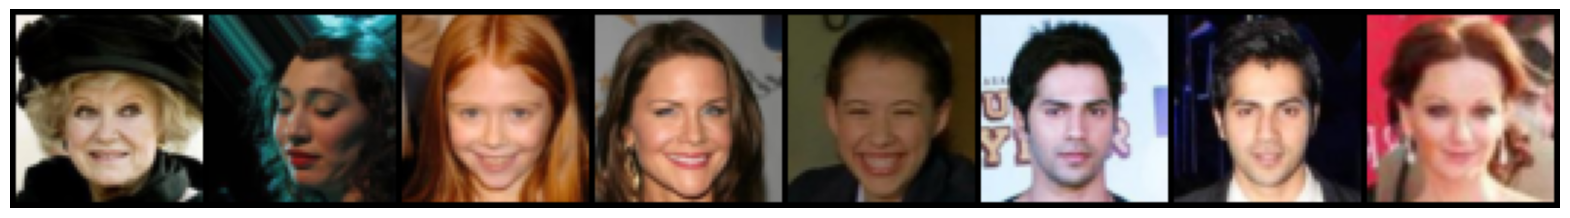

C:\Users\ruben\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoint loaded from Hugging Face


In [3]:


import os
import torch
from torchvision import datasets as Datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Parameters
batch_size = 64
image_size = 64
lr = 1e-4
nepoch = 100
start_epoch = 0
model_name = "CelebA"
load_checkpoint = True
save_dir = os.getcwd()
use_cuda = torch.cuda.is_available()
gpu_indx = 0
device = torch.device(f"cuda:{gpu_indx}" if use_cuda else "cpu")

# Download location (will automatically create and extract here)
dataset_root = os.path.join(save_dir, "celeba_data")

# Transform for CelebA
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Download & prepare CelebA
def get_data_celeba(transform, batch_size, download=False, root="celeba_data"):
    print("Downloading (if needed) and loading CelebA...")

    train_dataset = Datasets.CelebA(root=root, split="train", transform=transform, download=download)
    test_dataset  = Datasets.CelebA(root=root, split="test",  transform=transform, download=download)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print("Done loading CelebA.")
    return trainloader, testloader

# Load CelebA
trainloader, testloader = get_data_celeba(transform, batch_size, download=False, root=dataset_root)

# Preview some test images
dataiter = iter(testloader)
test_images, _ = next(dataiter)

plt.figure(figsize=(20, 10))
out = vutils.make_grid(test_images[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.show()



# Create the feature loss module
feature_extractor = VGG19().to(device)


#Create VAE network
vae_net = VAE(channel_in=3, ch=64, latent_channels=512).to(device)
# setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
# #Loss function
loss_log = []




# #Create the save directory if it does note exist
# if not os.path.isdir(save_dir + "/Models"):
#     os.makedirs(save_dir + "/Models")
# if not os.path.isdir(save_dir + "/Results"):
#     os.makedirs(save_dir + "/Results")



from huggingface_hub import hf_hub_download

if load_checkpoint:
    # Replace with your actual repo and filename on Hugging Face
    hf_repo = "rubenlier/VAEcelebrities"
    filename = "CelebA_64.pt"  # or whatever you named it when uploading

    # Download the file from Hugging Face (cached locally if already downloaded)
    model_path = hf_hub_download(repo_id=hf_repo, filename=filename)

    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location="cpu")
    print("Checkpoint loaded from Hugging Face")

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint["epoch"]
    loss_log = checkpoint["loss_log"]
else:
    #If checkpoint does exist raise an error to prevent accidental overwriting
    if os.path.isfile(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt"):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")


# In[ ]:





# In[ ]:







# Checking the reconstruction

Below are some reconstructions of the VAE of the input, you see it works decently well.

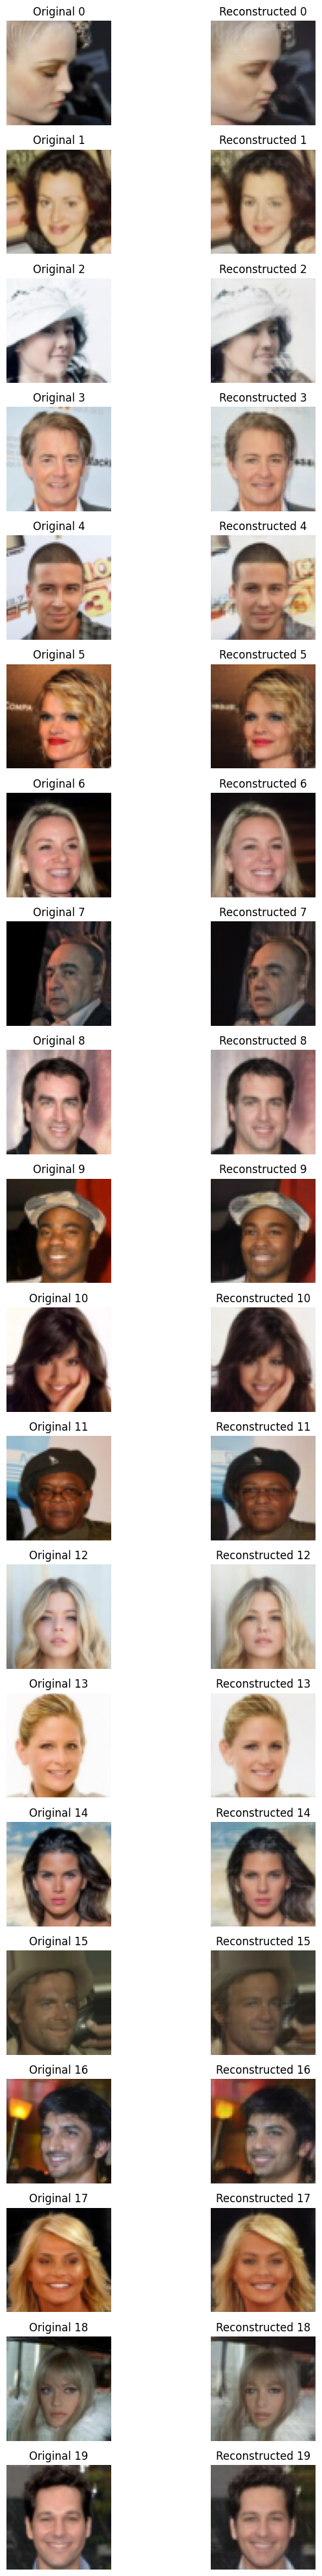

In [4]:
import matplotlib.pyplot as plt

vae_net.eval()
with torch.no_grad():
    test_images, _ = next(iter(testloader))  # get a batch of images
    n = min(20, test_images.size(0))         # make sure batch has at least 20

    plt.figure(figsize=(8, 2 * n))           # one row per image

    for i in range(n):
        x = test_images[40+i:40+i+1].to(device)    # shape: [1, 3, 64, 64]
        recon, _, _ = vae_net(x)

        # Unnormalize
        x_disp = (x.squeeze(0).cpu() + 1) / 2
        recon_disp = (recon.squeeze(0).cpu() + 1) / 2

        # Plot original
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(x_disp.permute(1, 2, 0).numpy())
        plt.title(f"Original {i}")
        plt.axis("off")

        # Plot reconstruction
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(recon_disp.permute(1, 2, 0).numpy())
        plt.title(f"Reconstructed {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Combining faces

Now we can play around a bit. Let's see what happens if you take 50% of one input and 50% of another. As you can see, this leads to bad results when the faces 
are pointed in different directions.

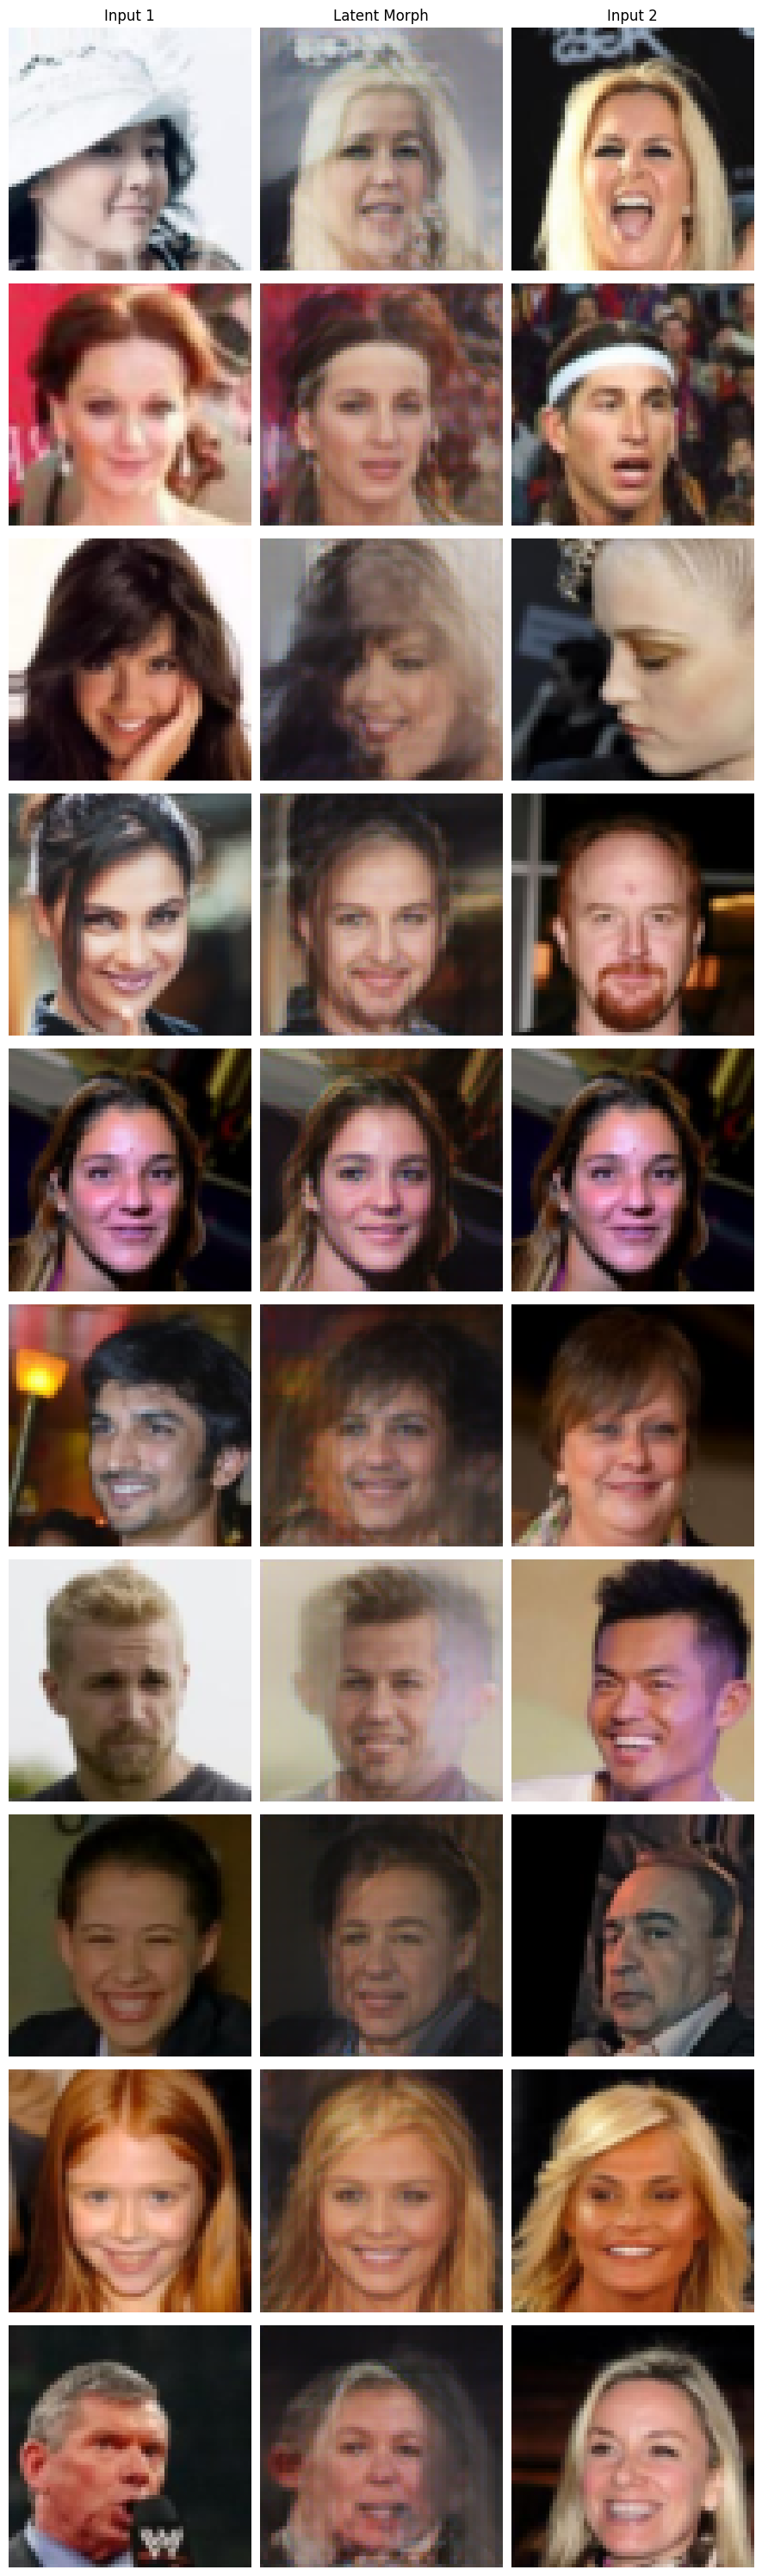

In [5]:
vae_net.eval()

import matplotlib.pyplot as plt

# Get enough test images in one batch
test_images, _ = next(iter(testloader))  # shape: [B, 3, 64, 64]
num_pairs = 10

plt.figure(figsize=(9, 3 * num_pairs))

with torch.no_grad():
    for i in range(num_pairs):
        # Select two random indices from the batch
        idx1, idx2 = torch.randint(0, len(test_images), (2,))
        x1 = test_images[idx1:idx1+1].to(device)
        x2 = test_images[idx2:idx2+1].to(device)

        # Encode
        _, mu1, _ = vae_net.encoder(x1)
        _, mu2, _ = vae_net.encoder(x2)

        # Interpolate
        mu_avg = 0.5 * mu1 + 0.5 * mu2
        x_interp = vae_net.decoder(mu_avg)

        # Unnormalize
        x1_disp = (x1.squeeze(0).cpu() + 1) / 2
        x2_disp = (x2.squeeze(0).cpu() + 1) / 2
        x_interp_disp = (x_interp.squeeze(0).cpu() + 1) / 2

        # Plot row
        plt.subplot(num_pairs, 3, 3 * i + 1)
        plt.imshow(x1_disp.permute(1, 2, 0).numpy())
        plt.axis("off")
        if i == 0:
            plt.title("Input 1")

        plt.subplot(num_pairs, 3, 3 * i + 2)
        plt.imshow(x_interp_disp.permute(1, 2, 0).numpy())
        plt.axis("off")
        if i == 0:
            plt.title("Latent Morph")

        plt.subplot(num_pairs, 3, 3 * i + 3)
        plt.imshow(x2_disp.permute(1, 2, 0).numpy())
        plt.axis("off")
        if i == 0:
            plt.title("Input 2")

plt.tight_layout()
plt.show()



# Make the morphing gif

Below is code to make a gif that morphs from a single base image into other images as shown in the readme. I chose a particular base for which I thought the image was nicely reconstructed to make the gif look better.


In [6]:
#make the morphing picture


import torch
import imageio
import numpy as np
from torchvision.utils import make_grid

def latent_morph_grid_gif(vae_net, test_images, device, out_path="morph_roster.gif", N=25, frames_per_half=20):
    vae_net.eval()

    with torch.no_grad():
        # Base image → z₀
        x0 = test_images[48:1+48].to(device)
        _, z0, _ = vae_net.encoder(x0)  # [1, 512, 1, 1]

        # Select N target latents z₁ ... z_N
        zn_list = []
        for i in range(1, N + 1):
            xi = test_images[i:i+1].to(device)
            _, zi, _ = vae_net.encoder(xi)
            zn_list.append(zi)

        # Prepare symmetric interpolation path: 0 → 1 → 0
        alphas = torch.linspace(0, 1, frames_per_half).tolist()
        alphas += alphas[::-1][1:]  # Ping-pong for smooth loop

        frames = []
        for alpha in alphas:
            # Interpolate all N in latent space
            z_stack = torch.cat([(1 - alpha) * z0 + alpha * zn for zn in zn_list], dim=0)  # shape: [N, 512, 1, 1]
            recon = vae_net.decoder(z_stack)  # [N, 3, 64, 64]
            recon = (recon + 1) / 2  # rescale to [0,1]

            # Arrange into 5×5 grid
            grid = make_grid(recon.cpu(), nrow=5, pad_value=1)
            grid_img = (grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            frames.append(grid_img)

        # Save animated GIF
        imageio.mimsave(out_path, frames, fps=10)

# Example usage
test_images, _ = next(iter(testloader))  # batch of test faces
latent_morph_grid_gif(vae_net, test_images, device, out_path="morph_roster.gif", N=25, frames_per_half=20)



# Make the morphing gif for julia roberts (disappointing result)

With the classifier I figured out which images in the celebA dataset belong to Julia Roberts. Now I can use these Julia Roberts images to make a gif. The result is very bad, it does not look like Julia Roberts at all. This is quite unfortunate, there are many reconstructions that were quite decent but somehow this model completely fails at reconstructing Julia Roberts even though Julia Roberts is probably better represented in the training set than 99% of the other people that are in there. 

In [7]:
import os
import torch
import imageio
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid

# List of selected images (originally labeled 4990 + one extra)
target_images = [
    "123073.jpg", "124103.jpg", "130450.jpg", "138241.jpg", "138760.jpg",
    "161768.jpg", "002893.jpg", "003997.jpg", "020255.jpg", "030154.jpg",
    "039712.jpg", "044212.jpg", "044481.jpg", "048616.jpg", "074409.jpg",
    "079943.jpg", "082500.jpg", "083985.jpg", "095630.jpg", "095899.jpg",
    "109790.jpg", "122653.jpg"
]

# Load these images into a tensor
def load_images(image_filenames, image_folder, transform):
    images = []
    for filename in image_filenames:
        path = os.path.join(image_folder, filename)
        if os.path.exists(path):
            img = Image.open(path).convert("RGB")
            images.append(transform(img))
        else:
            print(f"❌ Missing: {filename}")
    return torch.stack(images)

# Morphing function using selected images with base index 6
def latent_morph_grid_gif_from_list(vae_net, images_tensor, device, out_path="morph_roster_roberts.gif", frames_per_half=20):
    vae_net.eval()
    base_index = 6  # use image 6 as the base

    with torch.no_grad():
        # Base latent vector z0
        x0 = images_tensor[base_index:base_index+1].to(device)
        _, z0, _ = vae_net.encoder(x0)

        # Latent vectors of all other images
        zn_list = []
        for i in range(len(images_tensor)):
            if i == base_index:
                continue  # skip base image
            xi = images_tensor[i:i+1].to(device)
            _, zi, _ = vae_net.encoder(xi)
            zn_list.append(zi)

        # Create interpolation schedule
        alphas = torch.linspace(0, 1, frames_per_half).tolist()
        alphas += alphas[::-1][1:]

        # Generate frames
        frames = []
        for alpha in alphas:
            z_stack = torch.cat([(1 - alpha) * z0 + alpha * zn for zn in zn_list], dim=0)
            recon = vae_net.decoder(z_stack)
            recon = (recon + 1) / 2  # scale to [0,1]

            grid = make_grid(recon.cpu(), nrow=5, pad_value=1)
            grid_img = (grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            frames.append(grid_img)

        imageio.mimsave(out_path, frames, fps=10)
        print(f"✅ Saved: {out_path}")

# === USAGE ===

# Path to aligned CelebA images
image_folder = r"celeba_data\celeba\img_align_celeba"

# Standard VAE transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
    transforms.Normalize([0.5]*3, [0.5]*3)  # scales to [-1, 1]
])


# Load selected images and generate morphing GIF
images_tensor = load_images(target_images, image_folder, transform)
latent_morph_grid_gif_from_list(vae_net, images_tensor, device, out_path="morph_roster_roberts.gif", frames_per_half=20)


✅ Saved: morph_roster_roberts.gif



# How to still make a gif that looks like Julia Roberts

To remedy this disappointing result, we are now going to train our model a bit further to make it learn reconstructing Julia Roberts better. We do 
this by training the model exclusively on the few celebA pictures that we have of Julia Roberts. This is all very antithetical to the typical ML approach which is all about using much data and not training to only learn how to lower the loss for a small training set, but look where the typical 
ML approach has brought us...



In [ ]:
julia_filenames = [
    "123073.jpg", "124103.jpg", "130450.jpg", "138241.jpg", "138760.jpg",
    "161768.jpg", "002893.jpg", "003997.jpg", "020255.jpg", "030154.jpg",
    "039712.jpg", "044212.jpg", "044481.jpg", "048616.jpg", "074409.jpg",
    "079943.jpg", "082500.jpg", "083985.jpg", "095630.jpg", "095899.jpg",
    "109790.jpg", "122653.jpg"
]



from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class JuliaRobertsDataset(Dataset):
    def __init__(self, image_folder, filenames, transform=None):
        self.image_folder = image_folder
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label

# Path to CelebA image folder (adjust if needed)
image_folder = r"celeba_data\celeba\img_align_celeba"

# Transform (same as used for VAE)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # for range [-1, 1]
])

# Dataset and loader
julia_dataset = JuliaRobertsDataset(image_folder, julia_filenames, transform)
trainloader = DataLoader(julia_dataset, batch_size=16, shuffle=True)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class JuliaRobertsDataset(Dataset):
    def __init__(self, image_folder, filenames, transform=None):
        self.image_folder = image_folder
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label

# Path to CelebA image folder (adjust if needed)
image_folder = r"celeba_data\celeba\img_align_celeba"

# Transform (same as used for VAE)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # for range [-1, 1]
])

# Dataset and loader
julia_dataset = JuliaRobertsDataset(image_folder, julia_filenames, transform)
trainloader = DataLoader(julia_dataset, batch_size=16, shuffle=True)


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, _ = next(iter(trainloader))
grid = make_grid((images + 1) / 2, nrow=6)
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()



# Overfitting Julia Roberts

Below is the learning process. One thing that is changed is that we choose add a factor 0.02 for the KL loss. This is because we care about reconstruction, we have far too few images in our training set to hope that we would be able to obtain a nice smooth distribution of Julia Roberts images when training on this tiny training set. This means that we essentially turn our VAE into an AE but that is the price we have to pay. I also add a gradual lowering of the learning rate (through a uniform
factor on the loss function) so that it learns to better reconstruct the fine details, in particular I found earlier that it refused to produce open 
lip smiles which is somewhat solved by running it longer with a learning rate that decreases.



In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def kl(mu, logvar):
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

# Main loop
for epoch in range(150):
    vae_net.train()
    epoch_loss = 0.0

    for images, _ in trainloader:
        images = images.to(device)

        recon_img, mu, logvar = vae_net(images)
        kl_loss = kl(mu, logvar)
        mse_loss = F.mse_loss(recon_img, images)

        feat_in = torch.cat((recon_img, images), 0)
        feature_loss = feature_extractor(feat_in)

        loss = (0.02*kl_loss + mse_loss + feature_loss)/(np.exp(epoch*np.log(10)/149))
        epoch_loss += loss.item()

        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{nepoch}, Loss: {epoch_loss:.4f}")

    # === Show reconstruction of 3 random images from trainloader ===
    vae_net.eval()
    with torch.no_grad():
        for images, _ in trainloader:
            images = images[:3].to(device)  # just grab 3 from first available batch
            recon_img, _, _ = vae_net(images)
            break  # only need one batch

        # Unnormalize
        original = (images.cpu() + 1) / 2
        recon = (recon_img.cpu() + 1) / 2

        combined = torch.cat([original, recon], dim=0)
        grid = make_grid(combined, nrow=3)

        plt.figure(figsize=(6, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.title(f"Epoch {epoch + 1}: Top = original, Bottom = reconstruction")
        plt.axis("off")
        plt.show()



# New gif of Julia Roberts

Below we make the new gif of Julia Roberts morphing into a different Julia Roberts. This looks much better, except that somehow this VAE is not able
to allow for Julia Roberts to make an open lip smile. This was already the case for the earlier gif and apparently this small training set is not enough 
to make the model realize that by giving Julia Roberts an open lip smile the loss can be lowered. 


In [ ]:
import os
import torch
import imageio
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid

# List of selected images (originally labeled 4990 + one extra)
target_images = [
    "123073.jpg", "124103.jpg", "130450.jpg", "138241.jpg", "138760.jpg",
    "161768.jpg", "002893.jpg", "003997.jpg", "020255.jpg", "030154.jpg",
    "039712.jpg", "044212.jpg", "044481.jpg", "048616.jpg", "074409.jpg",
    "079943.jpg", "082500.jpg", "083985.jpg", "095630.jpg", "095899.jpg",
    "109790.jpg", "122653.jpg"
]

# Load these images into a tensor
def load_images(image_filenames, image_folder, transform):
    images = []
    for filename in image_filenames:
        path = os.path.join(image_folder, filename)
        if os.path.exists(path):
            img = Image.open(path).convert("RGB")
            images.append(transform(img))
        else:
            print(f"❌ Missing: {filename}")
    return torch.stack(images)

# Morphing function using selected images with base index 6
def latent_morph_grid_gif_from_list(vae_net, images_tensor, device, out_path="morph_roster_overtrained.gif", frames_per_half=20):
    vae_net.eval()
    base_index = 6  # use image 6 as the base

    with torch.no_grad():
        # Base latent vector z0
        x0 = images_tensor[base_index:base_index+1].to(device)
        _, z0, _ = vae_net.encoder(x0)

        # Latent vectors of all other images
        zn_list = []
        for i in range(len(images_tensor)):
            if i == base_index:
                continue  # skip base image
            xi = images_tensor[i:i+1].to(device)
            _, zi, _ = vae_net.encoder(xi)
            zn_list.append(zi)

        # Create interpolation schedule
        alphas = torch.linspace(0, 1, frames_per_half).tolist()
        alphas += alphas[::-1][1:]

        # Generate frames
        frames = []
        for alpha in alphas:
            z_stack = torch.cat([(1 - alpha) * z0 + alpha * zn for zn in zn_list], dim=0)
            recon = vae_net.decoder(z_stack)
            recon = (recon + 1) / 2  # scale to [0,1]

            grid = make_grid(recon.cpu(), nrow=5, pad_value=1)
            grid_img = (grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            frames.append(grid_img)

        imageio.mimsave(out_path, frames, fps=10)
        print(f"✅ Saved: {out_path}")

# === USAGE ===

# Path to aligned CelebA images
image_folder = r"celeba_data\celeba\img_align_celeba"

# Standard VAE transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
    transforms.Normalize([0.5]*3, [0.5]*3)  # scales to [-1, 1]
])


# Load selected images and generate morphing GIF
images_tensor = load_images(target_images, image_folder, transform)
latent_morph_grid_gif_from_list(vae_net, images_tensor, device, out_path="morph_roster_overtrained.gif", frames_per_half=20)
